Average number of contours per image: 8.301612903225806
Average contour area: 152.04517194482221
Average contour perimeter: 34.870328388655096
Max number of contours in an image: 47
Min number of contours in an image: 0


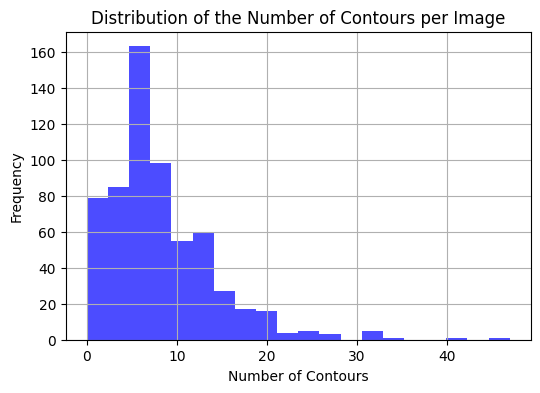

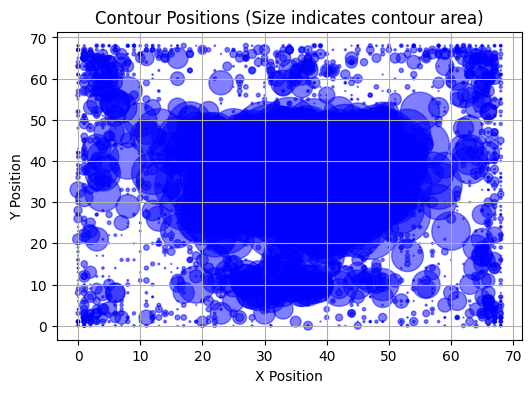

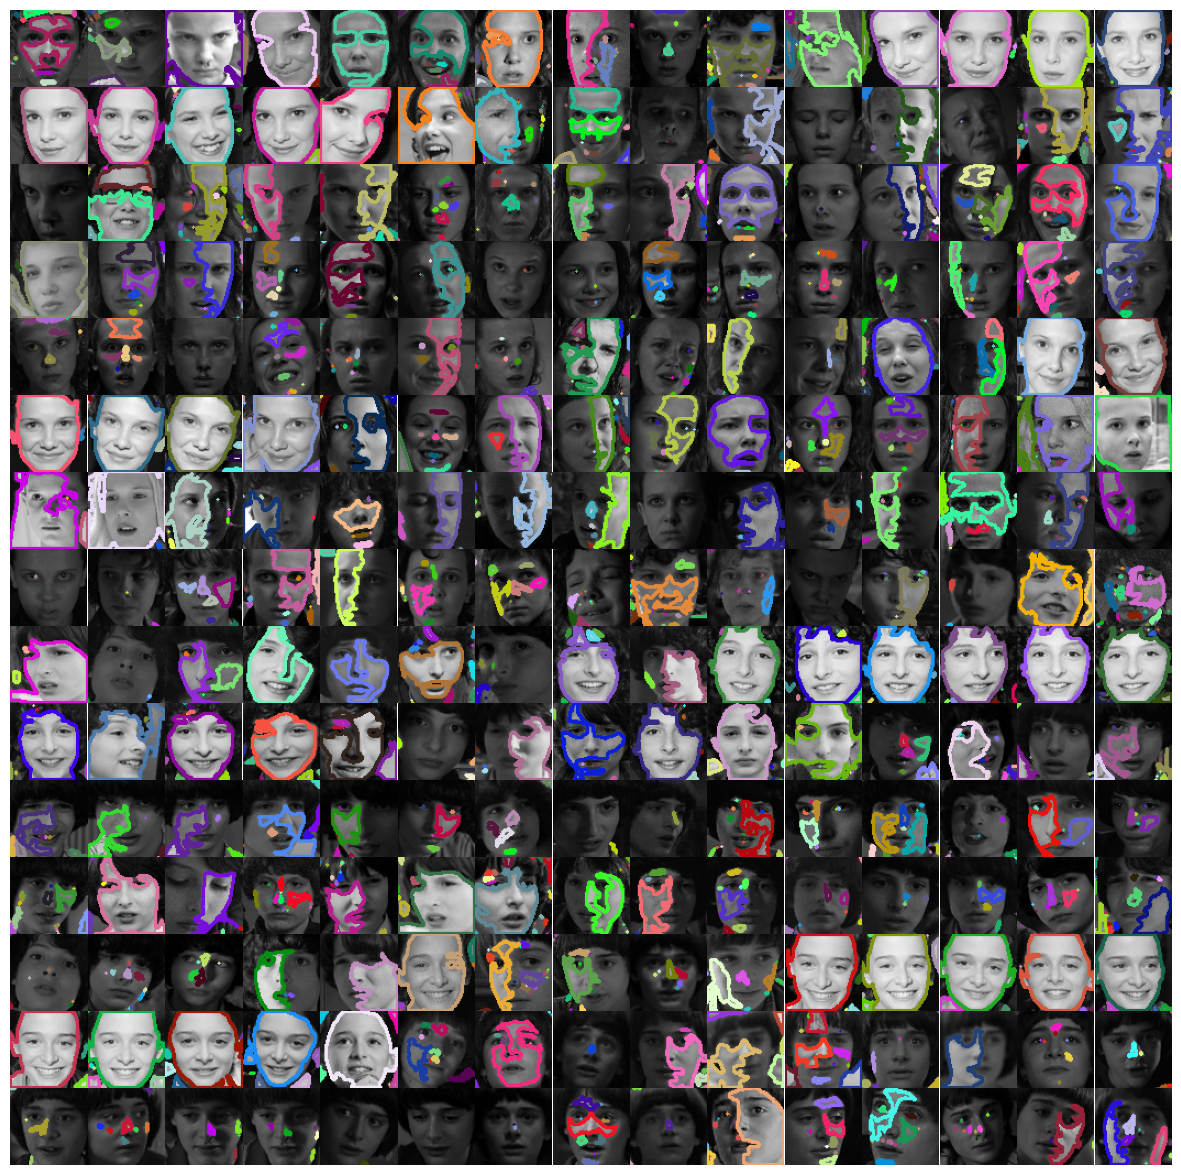

In [3]:
import os
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# Function to collect all images from a folder (including subfolders)
def collect_images_from_folder(folder_path):
    image_paths = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                image_paths.append(os.path.join(root, file))
    return image_paths

# Function to generate random color
def random_color():
    return [random.randint(0, 255) for _ in range(3)]

# Function to apply contour detection to each image and collect statistics
def apply_contour_detection(image_paths):
    contour_statistics = []  # To store stats for each image
    contour_detected_images = []

    all_contour_areas = []      # Collect all contour areas for statistics
    all_contour_perimeters = [] # Collect all contour perimeters for statistics
    num_contours_per_image = [] # Track the number of contours per image
    contour_positions = []      # Track position (centroid) for each contour

    for img_path in image_paths:
        img = Image.open(img_path).convert('L').resize((70, 70))  # Grayscale and resize
        img_array = np.array(img)

        # Convert to OpenCV format
        im_cv = img_array.astype(np.uint8)

        # Apply threshold to binarize the image
        _, thresholded = cv2.threshold(im_cv, 100, 255, cv2.THRESH_BINARY)

        # Find contours
        contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Draw contours on the original image with random colors
        contour_image = cv2.cvtColor(im_cv, cv2.COLOR_GRAY2BGR)  # Convert to color for drawing colored contours
        contour_info = []

        for cnt in contours:
            color = random_color()  # Generate a random color for each contour
            cv2.drawContours(contour_image, [cnt], -1, color, 2)  # Draw contour

            # Calculate area, perimeter, and centroid
            area = cv2.contourArea(cnt)
            perimeter = cv2.arcLength(cnt, True)
            M = cv2.moments(cnt)
            if M['m00'] != 0:
                cx = int(M['m10'] / M['m00'])  # x coordinate of centroid
                cy = int(M['m01'] / M['m00'])  # y coordinate of centroid
                contour_positions.append((cx, cy, area))  # Store centroid position and area

            contour_info.append((area, perimeter))

            # Add to overall statistics
            all_contour_areas.append(area)
            all_contour_perimeters.append(perimeter)

        # Store statistics for the current image
        num_contours = len(contours)
        num_contours_per_image.append(num_contours)
        
        contour_statistics.append({
            'num_contours': num_contours,
            'contour_info': contour_info
        })

        # Append the image with drawn contours to the list
        contour_detected_images.append(contour_image)

    # Calculate summary statistics
    avg_num_contours = np.mean(num_contours_per_image)
    avg_contour_area = np.mean(all_contour_areas) if all_contour_areas else 0
    avg_contour_perimeter = np.mean(all_contour_perimeters) if all_contour_perimeters else 0
    max_num_contours = max(num_contours_per_image, default=0)
    min_num_contours = min(num_contours_per_image, default=0)

    # Print the calculated statistics
    print("Average number of contours per image:", avg_num_contours)
    print("Average contour area:", avg_contour_area)
    print("Average contour perimeter:", avg_contour_perimeter)
    print("Max number of contours in an image:", max_num_contours)
    print("Min number of contours in an image:", min_num_contours)

    return contour_detected_images, contour_statistics, num_contours_per_image, contour_positions

# Function to display images in a grid
def display_images_in_grid(images, rows=15, cols=15):
    total_images = rows * cols
    images_to_display = images[:total_images]

    fig, axs = plt.subplots(rows, cols, figsize=(cols, rows), gridspec_kw={'wspace': 0, 'hspace': 0})
    plt.subplots_adjust(wspace=0, hspace=0)

    for i, ax in enumerate(axs.ravel()):
        if i < len(images_to_display):
            ax.imshow(cv2.cvtColor(images_to_display[i], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct colors
            ax.axis('off')  
        else:
            ax.axis('off')  

    plt.show()

# Function to plot histogram and scatter plot
def plot_statistics(num_contours_per_image, contour_positions):
    # Histogram of the number of contours per image
    plt.figure(figsize=(6, 4))
    plt.hist(num_contours_per_image, bins=20, color='blue', alpha=0.7)
    plt.title('Distribution of the Number of Contours per Image')
    plt.xlabel('Number of Contours')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Scatter plot of contour positions with size indicating area
    if contour_positions:
        x_positions = [pos[0] for pos in contour_positions]
        y_positions = [pos[1] for pos in contour_positions]
        areas = [pos[2] for pos in contour_positions]

        plt.figure(figsize=(6, 4))
        plt.scatter(x_positions, y_positions, s=areas, alpha=0.5, c='blue')
        plt.title('Contour Positions (Size indicates contour area)')
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.grid(True)
        plt.show()

# Folder containing the images
path = r"C:\Users\asmun\OneDrive - NTNU\H24\Datadrevet\it3212-data-driven-software\datasets\x86"

# Collect all image paths
image_paths = collect_images_from_folder(path)

# Apply contour detection to the collected images
contour_detected_images, contour_statistics, num_contours_per_image, contour_positions = apply_contour_detection(image_paths)

# Plot statistics
plot_statistics(num_contours_per_image, contour_positions)

# Display contour-detected images in a grid
display_images_in_grid(contour_detected_images, rows=15, cols=15)
